**SYPA: Fundamental Analysis of Foreign Direct Investment** <br>
*4_Model_Selection* <br>
Harvard SYPA <br>
User: Jake Schneider <br>
Date Created: February 29, 2020 <br>
Date Updated: February 29, 2020

----

**Model Selection Strategy** <br>
1. Lasso <br>
2. Random Forest <br>
3. Neural Networks

**Load Packages**

In [1]:
#Import libraries
import sys
import pandas as pd
from datetime import date, datetime, time, timedelta
import pendulum
import json
import requests
import numpy as np
import math

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style='ticks', context='talk')

from matplotlib.offsetbox import AnchoredText
from sklearn import metrics
from sklearn import linear_model
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor 

import statsmodels.formula.api as sm
from pprint import pprint

import warnings
import itertools

import missingno as msno

from flask import jsonify, make_response

from varname import varname

from matplotlib.backends.backend_pdf import PdfPages
from fpdf import FPDF
from PIL import Image, ImageDraw, ImageFont

----

**Load Data**

In [2]:
# Load Data

final_df = pd.read_csv('../../2_Inputs/Final/final_df.csv')
final_df = final_df.drop(["Unnamed: 0"], axis = 1)
final_df.head()

,country,date,code,iso2Code,region,adminregion,incomeLevel,lendingType,capitalCity,longitude,...,Labor.force.participation.rate..total....of.total.population.ages.15.64...modeled.ILO.estimate.,Ratio.of.female.to.male.labor.force.participation.rate......modeled.ILO.estimate.,Unemployment..total....of.total.labor.force...modeled.ILO.estimate.,Net.migration,Prevalence.of.undernourishment....of.population.,Life.expectancy.at.birth..total..years.,Fertility.rate..total..births.per.woman.,Population.ages.65.and.above....of.total.population.,Unmet.need.for.contraception....of.married.women.ages.15.49.,Voice.and.Accountability..Estimate.y
0,Afghanistan,1960.0,AFG,AF,South Asia,South Asia,Low income,IDA,Kabul,69.1761,...,61.736799,74.856875,4.1602,276087.2,13.9,32.446,7.45,2.798308,15.06,-0.199767
1,Afghanistan,1961.0,AFG,AF,South Asia,South Asia,Low income,IDA,Kabul,69.1761,...,61.736799,74.856875,7.6538,195999.6,13.9,32.962,7.45,2.808131,15.06,-0.199767
2,Afghanistan,1962.0,AFG,AF,South Asia,South Asia,Low income,IDA,Kabul,69.1761,...,69.058401,71.941730,5.2414,-20000.0,13.9,33.471,7.45,2.804113,15.06,-0.199767
3,Afghanistan,1963.0,AFG,AF,South Asia,South Asia,Low income,IDA,Kabul,69.1761,...,63.873800,54.693568,7.0762,278921.8,13.9,33.971,7.45,2.786171,15.06,-0.193007
4,Afghanistan,1964.0,AFG,AF,South Asia,South Asia,Low income,IDA,Kabul,69.1761,...,66.003000,59.874157,6.8932,195999.6,13.9,34.463,7.45,2.754223,15.06,-0.193007


In [3]:
# Print Shape

final_df.shape

(13020, 2323)

---

**Split Data into In-Sample and Lock Box**

In [4]:
# Create in-sample

in_sample = final_df[final_df['date'] <= 2014]
print("In-sample Dimensions:", in_sample.shape)
print(in_sample['date'].describe())
in_sample.to_csv('../../2_Inputs/Final/in_sample.csv')
in_sample.head()

In-sample Dimensions: (11935, 2323)
count    11935.000000
mean      1987.000000
std         15.875173
min       1960.000000
25%       1973.000000
50%       1987.000000
75%       2001.000000
max       2014.000000
Name: date, dtype: float64


,country,date,code,iso2Code,region,adminregion,incomeLevel,lendingType,capitalCity,longitude,...,Labor.force.participation.rate..total....of.total.population.ages.15.64...modeled.ILO.estimate.,Ratio.of.female.to.male.labor.force.participation.rate......modeled.ILO.estimate.,Unemployment..total....of.total.labor.force...modeled.ILO.estimate.,Net.migration,Prevalence.of.undernourishment....of.population.,Life.expectancy.at.birth..total..years.,Fertility.rate..total..births.per.woman.,Population.ages.65.and.above....of.total.population.,Unmet.need.for.contraception....of.married.women.ages.15.49.,Voice.and.Accountability..Estimate.y
0,Afghanistan,1960.0,AFG,AF,South Asia,South Asia,Low income,IDA,Kabul,69.1761,...,61.736799,74.856875,4.1602,276087.2,13.9,32.446,7.45,2.798308,15.06,-0.199767
1,Afghanistan,1961.0,AFG,AF,South Asia,South Asia,Low income,IDA,Kabul,69.1761,...,61.736799,74.856875,7.6538,195999.6,13.9,32.962,7.45,2.808131,15.06,-0.199767
2,Afghanistan,1962.0,AFG,AF,South Asia,South Asia,Low income,IDA,Kabul,69.1761,...,69.058401,71.941730,5.2414,-20000.0,13.9,33.471,7.45,2.804113,15.06,-0.199767
3,Afghanistan,1963.0,AFG,AF,South Asia,South Asia,Low income,IDA,Kabul,69.1761,...,63.873800,54.693568,7.0762,278921.8,13.9,33.971,7.45,2.786171,15.06,-0.193007
4,Afghanistan,1964.0,AFG,AF,South Asia,South Asia,Low income,IDA,Kabul,69.1761,...,66.003000,59.874157,6.8932,195999.6,13.9,34.463,7.45,2.754223,15.06,-0.193007


In [5]:
# Create Lock Box

lock_box = final_df[final_df['date'] > 2014]
print("Lock Box Dimensions:", lock_box.shape)
print(lock_box['date'].describe())
lock_box.to_csv('../../2_Inputs/Final/lock_box.csv')
lock_box.head()

Lock Box Dimensions: (1085, 2323)
count    1085.000000
mean     2017.000000
std         1.414866
min      2015.000000
25%      2016.000000
50%      2017.000000
75%      2018.000000
max      2019.000000
Name: date, dtype: float64


,country,date,code,iso2Code,region,adminregion,incomeLevel,lendingType,capitalCity,longitude,...,Labor.force.participation.rate..total....of.total.population.ages.15.64...modeled.ILO.estimate.,Ratio.of.female.to.male.labor.force.participation.rate......modeled.ILO.estimate.,Unemployment..total....of.total.labor.force...modeled.ILO.estimate.,Net.migration,Prevalence.of.undernourishment....of.population.,Life.expectancy.at.birth..total..years.,Fertility.rate..total..births.per.woman.,Population.ages.65.and.above....of.total.population.,Unmet.need.for.contraception....of.married.women.ages.15.49.,Voice.and.Accountability..Estimate.y
55,Afghanistan,2015.0,AFG,AF,South Asia,South Asia,Low income,IDA,Kabul,69.1761,...,66.914001,57.110746,1.679,52807.2,28.60,63.377000,4.9760,2.478662,24.50,-1.117563
56,Afghanistan,2016.0,AFG,AF,South Asia,South Asia,Low income,IDA,Kabul,69.1761,...,67.268997,58.104539,1.634,18138.6,29.50,63.763000,4.8000,2.519923,15.06,-1.039843
57,Afghanistan,2017.0,AFG,AF,South Asia,South Asia,Low income,IDA,Kabul,69.1761,...,67.606003,59.008129,1.559,-314602.0,29.80,64.130000,4.6330,2.554251,15.06,-0.992470
58,Afghanistan,2018.0,AFG,AF,South Asia,South Asia,Low income,IDA,Kabul,69.1761,...,67.686996,59.244647,1.542,52807.2,27.86,69.075083,2.1800,2.584927,15.06,-0.994720
59,Afghanistan,2019.0,AFG,AF,South Asia,South Asia,Low income,IDA,Kabul,69.1761,...,67.772003,59.479106,1.519,26108.8,3.68,66.443400,3.9094,8.794946,14.66,0.853073


----

**Model Selection**

*Prerequisites*

In [6]:
# Create Xs and Y

Xs = in_sample.drop(in_sample[['country', 'date', 'code', 'iso2Code', 'region', 'adminregion',
                      'incomeLevel', 'lendingType', 'capitalCity',
                      'Foreign direct investment, net inflows (% of GDP)']], axis = 1)
y = in_sample['Foreign direct investment, net inflows (% of GDP)'].values.reshape(-1,1)

In [7]:
# View Shapes Xs

print("Xs:", Xs.shape)
print("Y:", y.shape)

Xs: (11935, 2313)
Y: (11935, 1)


In [8]:
# Create Table For Storing Best Results

results = pd.DataFrame(columns = ['Model Name', 'Model Type', 'Minimum RMSE', 'Variables']) #'Accuracy', #'Maximum R2',
#results

*Linear Models* <br>
Docs: https://towardsdatascience.com/how-to-perform-lasso-and-ridge-regression-in-python-3b3b75541ad8 <br>
GridSearch: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html <br>
Variable Selection: https://datascienceplus.com/lasso-regression-in-python/ <br>

In [9]:
# See potential scoring metrics

#metrics.SCORERS.keys()

In [10]:
#Multivariate Regression

reg = LinearRegression()

reg_MSEs = cross_val_score(reg, Xs, y, scoring = 'neg_root_mean_squared_error', cv = 5)
#reg_accuracy = cross_val_score(reg, Xs, y, scoring = 'accuracy', cv = 5)
#reg_r2 = cross_val_score(reg, Xs, y, scoring = 'r2', cv = 5)

print("Test MSEs: \n", -reg_MSEs)
#print("Test Accuracy: \n", reg_accuracy)
#print("Test R2s: \n", reg_r2)

mean_reg_MSEs = np.mean(-reg_MSEs)
print("\nMean Test MSE from 5-Fold CV:", mean_reg_MSEs)

#mean_reg_accuracy = np.mean(reg_accuracy)
#print("\nMean Test Accuracy from 5-Fold CV:", mean_reg_accuracy)

#mean_reg_r2 = np.mean(reg_r2)
#print("Mean Test R2 from 5-Fold CV:", mean_reg_r2)

reg_results = pd.DataFrame({'Model Name': 'Linear Regression', 
                    'Model Type': 'Linear Model', 
                    #'Accuracy': [round(mean_reg_accuracy, 2)],        
                    'Minimum RMSE': [round(mean_reg_MSEs, 2)], 
                    #'Maximum R2': [round(mean_reg_r2, 2)], 
                    'Variables': [len(Xs.columns)]})

results = results.append(reg_results)
print("\nResults Dataframe: \n", results)

Test MSEs: 
 [3.65799649e+02 7.94927613e+01 1.05469867e+02 9.79305057e+01
 9.94607373e+04]

Mean Test MSE from 5-Fold CV: 20021.88601947811

Results Dataframe: 
           Model Name    Model Type  Minimum RMSE Variables
0  Linear Regression  Linear Model      20021.89      2313


In [11]:
#Ridge Regression

rmse_ridge = np.sqrt(-cross_val_score(Ridge(tol = 1, max_iter = 100), Xs, y, scoring="neg_mean_squared_error", cv = 5))
print("Test RMSEs: \n", rmse_ridge)

alphas = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20, 50, 100]

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, Xs, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

cv_rmse_ridge = [rmse_cv(Ridge(alpha = alpha, tol = 1, max_iter = 100)).mean() 
            for alpha in alphas]

cv_rmse_ridge = pd.Series(cv_rmse_ridge, index = alphas)
print("\nCross-Validated RMSEs:\n", cv_rmse_ridge)
print("Minimum Ridge RMSE:", round(cv_rmse_ridge.min(), 2))

#def accuracy_cv(model):
#    accuracy = cross_val_score(model, Xs, y, scoring="accuracy", cv = 5)
#    return(accuracy)
#
#cv_accuracy_ridge = [accuracy_cv(Ridge(alpha = alpha)).mean() 
#            for alpha in alphas]
#
#cv_accuracy_ridge = pd.Series(cv_accuracy_ridge, index = alphas)
#print("\nCross-Validated Accuracy:\n", cv_accuracy_ridge)
#print("Maximum Ridge Accuracy:", round(cv_accuracy_ridge.max(), 2))

Test RMSEs: 
 [13213.8285421     83.50134782  1702.61332901   109.5060169
 48048.21280857]

Cross-Validated RMSEs:
 1.000000e-15    14370.487856
1.000000e-10    14370.487853
1.000000e-08    14370.487683
1.000000e-04    14368.771064
1.000000e-03    14353.475228
1.000000e-02    14214.428490
1.000000e+00    12631.532409
5.000000e+00    12189.361587
1.000000e+01    12131.986744
2.000000e+01    12318.859965
5.000000e+01    13020.242572
1.000000e+02    13761.372691
dtype: float64
Minimum Ridge RMSE: 12131.99


In [12]:
# Store Ridge Results

optimum_ridge = RidgeCV(alphas = [10]).fit(Xs, y)
optimum_ridge.coef_[0]

coef = pd.Series(optimum_ridge.coef_[0], index = Xs.columns) 
print("Ridge Coefficients:\n",coef.head())

ridge_results = pd.DataFrame({'Model Name': 'Ridge Regression', 
                    'Model Type': 'Linear Model', 
                    #'Accuracy': [round(cv_accuracy_ridge.max(), 2)],
                    'Minimum RMSE': [round(cv_rmse_ridge.min(), 2)], 
                    #'Maximum R2': [np.max(ridge_r2)], 
                    'Variables': [np.sum((coef != 0))]})

results = results.append(ridge_results)
print("\nResults Dataframe:\n", results)

Ridge Coefficients:
 longitude                                                                    0.003134
latitude                                                                     1.597256
2005 PPP conversion factor, GDP (LCU per international $)                   -2.918842
2005 PPP conversion factor, private consumption (LCU per international $)    4.001213
Access to clean fuels and technologies for cooking (% of population)        -2.404181
dtype: float64

Results Dataframe:
           Model Name    Model Type  Minimum RMSE Variables
0  Linear Regression  Linear Model      20021.89      2313
0   Ridge Regression  Linear Model      12131.99      2310


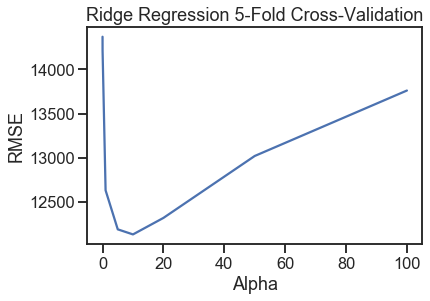

In [13]:
# Plot Ridge Regression

cv_rmse_ridge.plot(title = "Ridge Regression 5-Fold Cross-Validation")
plt.xlabel("Alpha")
plt.ylabel("RMSE")
plt.plot()
#sns.despine()
plt.savefig('../../3_Outputs/Model Selection/Ridge Regression/Ridge Regression CV RMSE Plot.jpg')

In [14]:
##Ridge Regression 2
#
#ridge = Ridge()
#
#parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20, 50, 100]}
#
#ridge_regressor_MSE = GridSearchCV(ridge, parameters, scoring='neg_root_mean_squared_error', cv = 5, verbose = 1, n_jobs = 2)
#ridge_regressor_r2 = GridSearchCV(ridge, parameters, scoring = 'r2', cv = 5, verbose = 1, n_jobs = 2)
#
#
#ridge_MSEs = ridge_regressor_MSE.fit(Xs, y)
#ridge_r2 = ridge_regressor_r2.fit(Xs, y)
#
#print("Test MSEs: \n", ridge_MSEs)
#print("Test R2s: \n", ridge_r2)
#
#print("\nMSE Ridge Regressor Best Parameters:", ridge_regressor_MSE.best_params_)
#print("MSE Ridge Regressor Best Score:", ridge_regressor_MSE.best_score_)
#
#
#print("\nR2 Ridge Regressor Best Parameters:", ridge_regressor_r2.best_params_)
#print("R2 Ridge Regressor Best Score:", ridge_regressor_r2.best_score_)
#
#
#ridge_results = pd.DataFrame({'Model Name': 'Ridge Regression', 
#                    'Model Type': 'Linear Model', 
#                    'Best MSE': [np.max(ridge_MSEs)], 
#                    'Best R2': [np.max(ridge_r2)], 
#                    #'Variables': [np.sum(ridge_regressor_MSE.coef_ != 0)]})
#
#results = results.append(ridge_results)
#print("\nResults Dataframe:", results)

In [15]:
#Lasso Regression

rmse_lasso = np.sqrt(-cross_val_score(Lasso(tol = 1, max_iter = 100), Xs, y, scoring="neg_mean_squared_error", cv = 5))
print("Test RMSEs: \n", rmse_lasso)

alphas = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20, 50, 100]

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, Xs, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

cv_rmse_lasso = [rmse_cv(Lasso(alpha = alpha, tol = 1, max_iter = 100)).mean() 
            for alpha in alphas]

cv_rmse_lasso = pd.Series(cv_rmse_lasso, index = alphas)
print("\nCross-Validated RMSEs:\n", cv_rmse_lasso)
print("Minimum Ridge RMSE:", round(cv_rmse_lasso.min(), 2))

#def accuracy_cv(model):
#    accuracy = cross_val_score(model, Xs, y, scoring="accuracy", cv = 5)
#    return(accuracy)
#
#cv_accuracy_lasso = [accuracy_cv(Lasso(alpha = alpha)).mean() 
#            for alpha in alphas]
#
#cv_accuracy_lasso = pd.Series(cv_accuracy_lasso, index = alphas)
#print("\nCross-Validated Accuracy:\n", cv_accuracy_lasso)
#print("Maximum Ridge Accuracy:", round(cv_accuracy_lasso.max(), 2))

Test RMSEs: 
 [   88.90692131    79.53091517    90.48972044    85.92711845
 50927.46011451]

Cross-Validated RMSEs:
 1.000000e-15     6369.942321
1.000000e-10     6369.942319
1.000000e-08     6369.942062
1.000000e-04     6367.292311
1.000000e-03     6343.434955
1.000000e-02     6097.626854
1.000000e+00    10254.462958
5.000000e+00     4636.478089
1.000000e+01    10690.310680
2.000000e+01     8257.855953
5.000000e+01      462.401981
1.000000e+02     4389.098432
dtype: float64
Minimum Ridge RMSE: 462.4


In [16]:
# Store Lasso Results

optimum_lasso = LassoCV(alphas = [50], tol = 0.1).fit(Xs, y) #Change optimum
#print(optimum_lasso.coef_)

coef = pd.Series(optimum_lasso.coef_, index = Xs.columns) 
print("\nLasso Coefficients:\n",coef.head(100))

lasso_results = pd.DataFrame({'Model Name': 'Lasso Regression', 
                    'Model Type': 'Linear Model',
                    #'Accuracy': [round(cv_accuracy_lasso.max(), 2)],
                    'Minimum RMSE': [round(cv_rmse_lasso.min(), 2)], 
                    #'Maximum R2': [np.max(ridge_r2)], 
                    'Variables': [np.sum((coef != 0))]})

results = results.append(lasso_results)
print("\nResults Dataframe:\n", results)

results.to_csv('../../3_Outputs/Model Selection/Validation Table/Validation Table.csv')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23028251.179161232, tolerance: 10347766.997182533
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22945102.96945966, tolerance: 10599739.01627548
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You migh


Lasso Coefficients:
 longitude                                                                    0.000000e+00
latitude                                                                     0.000000e+00
2005 PPP conversion factor, GDP (LCU per international $)                    0.000000e+00
2005 PPP conversion factor, private consumption (LCU per international $)    5.244895e-04
Access to clean fuels and technologies for cooking (% of population)         8.361413e-02
                                                                                 ...     
Arable land (hectares)                                                       3.731161e-07
ARI treatment (% of children under 5 taken to a health provider)             0.000000e+00
Armed forces personnel (% of total labor force)                             -0.000000e+00
Armed forces personnel, total                                               -5.264754e-06
Arms exports (SIPRI trend indicator values)                                 -2

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29554906.414956357, tolerance: 13270713.99317551
  positive)


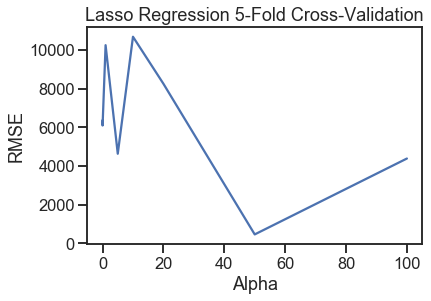

In [17]:
# Plot Lasso Regression

cv_rmse_lasso.plot(title = "Lasso Regression 5-Fold Cross-Validation")
plt.xlabel("Alpha")
plt.ylabel("RMSE")
plt.plot()
#sns.despine()
plt.savefig('../../3_Outputs/Model Selection/Lasso Regression/Lasso Regression CV RMSE Plot.jpg')

In [18]:
##Lasso Regression 2
#
#lasso = Lasso()
#
#parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20, 50, 100]}
#
#lasso_regressor_MSE = GridSearchCV(lasso, parameters, scoring='neg_root_mean_squared_error', cv = 5, verbose = 1, n_jobs = 2)
#lasso_regressor_r2 = GridSearchCV(lasso, parameters, scoring = 'r2', cv = 5, verbose = 1, n_jobs = 2)
#
#
#lasso_MSEs = lasso_regressor_MSE.fit(Xs, y)
#lasso_r2 = lasso_regressor_r2.fit(Xs, y)
#
#print("Test Lasso MSEs: \n", lasso_MSEs)
#print("Test Lasso R2s: \n", lasso_r2)
#
#mean_lasso_MSEs = np.mean(lasso_MSEs)
#print("\nMean Lasso Test MSE from 5-Fold CV:", mean_lasso_MSEs)
#print("MSE Lasso Regressor Best Parameters:", lasso_regressor_MSE.best_params_)
#print("MSE Lasso Regressor Best Score:", lasso_regressor_MSE.best_score_)
#
#mean_lasso_r2 = np.mean(lasso_r2)
#print("Mean Lasso Test R2 from 5-Fold CV:", mean_lasso_r2)
#print("R2 Lasso Regressor Best Parameters:", lasso_regressor_r2.best_params_)
#print("R2 Lasso Regressor Best Score:", lasso_regressor_r2.best_score_)
#
#lasso_results = pd.DataFrame({'Model Name': 'Lasso Regression', 
#                    'Model Type': 'Linear Model', 
#                    'Best MSE': [np.max(lasso_MSEs)], 
#                    'Best R2': [np.max(lasso_r2)], 
#                    #'Variables': [np.sum(lasso_regressor_r2.coef_ != 0)]})
#
#results = results.append(lasso_results)
#print("\nResults Dataframe:", results)

*Pure Regression for Litmus Test*

In [19]:
## Linear Regression
#
#reg_full = reg.fit(Xs, y)
#print("R2 for Linear Model with All Variables: ", round(reg_full.score(Xs, y)*100, 2))

In [20]:
# Full Summary
# R2: 72.3
# Adjusted R2: 71.0

model = sm.ols(formula='y ~ Xs', data=in_sample)
results1 = model.fit()
print("R2:", round(results1.rsquared*100, 2))
print(results1.summary())

R2: 72.34


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     52.42
Date:                Sun, 01 Mar 2020   Prob (F-statistic):               0.00
Time:                        14:06:45   Log-Likelihood:                -64862.
No. Observations:               11935   AIC:                         1.309e+05
Df Residuals:                   11367   BIC:                         1.351e+05
Df Model:                         567                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0428      0.085      0.506      0.6

In [21]:
print(Xs.iloc[:, [123, 128, 168, 177, 183, 212, 384, 459, 500, 504, 727, 755, 785, 862, 867, 872, 929, 964, 1104, 1105, 1122, 1143, 1199, 1200, 1204, 1231, 1360, 1528, 1546, 1567, 1681, 1682, 1980, 2071, 2185, 2186, 2187, 2193, 2203, 2210, 2228]].head(0))

Empty DataFrame
Columns: [Binding coverage, primary products (%), Bound rate, simple mean, all products (%), Children in employment, study and work (% of children in employment, ages 7-14), Children in employment, wage workers, male (% of male children in employment, ages 7-14), Children out of school, male (% of male primary school age), Commercial bank branches (per 100,000 adults), Employment to population ratio, ages 15-24, total (%) (national estimate), Foreign direct investment, net outflows (% of GDP), GNI per capita (constant 2010 US$), GNI per capita, Atlas method (current US$), Lower secondary completion rate, male (% of relevant age group), Merchandise exports to low- and middle-income economies in Middle East & North Africa (% of total merchandise exports), Mortality caused by road traffic injury (per 100,000 people), Net investment in nonfinancial assets (% of GDP), Net ODA provided to the least developed countries (% of GNI), Net ODA received (% of central government expe

In [22]:
# Model 2: Most Correlated Variables

model2 = sm.ols(formula='y ~ Xs.iloc[: , [123, 128, 168, 177, 183, 212, 384, 459, 500, 504, 727, 755, 785, 862, 867, 872, 929, 964, 1104, 1105, 1122, 1143, 1199, 1200, 1204, 1231, 1360, 1528, 1546, 1567, 1681, 1682, 1980, 2071, 2185, 2186, 2187, 2193, 2203, 2210, 2228]]', data=in_sample)
results2 = model2.fit()
print("R2:", round(results2.rsquared*100, 2))
print(results2.summary())

R2: 50.44
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.503
Method:                 Least Squares   F-statistic:                     295.2
Date:                Sun, 01 Mar 2020   Prob (F-statistic):               0.00
Time:                        14:06:46   Log-Likelihood:                -68342.
No. Observations:               11935   AIC:                         1.368e+05
Df Residuals:                   11893   BIC:                         1.371e+05
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                                                                                                                                                                                                        

*Tree Based* <br>
In 4b

*Neural Networks* <br>
In 4c

----

**Model Selection**

Choose best model in future workbooks.